# 01. Preprocessing & EDA (Beijing Multi-Site Air Quality)
Mục tiêu: tải dữ liệu, làm sạch, tạo nhãn phân lớp (AQI class theo PM2.5 24h mean), tạo đặc trưng thời gian + lag, và lưu `data/processed/cleaned.parquet`.

**Lưu ý:** nếu `USE_UCIMLREPO=True` thì notebook cần internet để tải dataset từ UCI.

In [1]:
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"

OUTPUT_CLEANED_PATH = 'data/processed/01_cleaned.parquet'
LAG_HOURS=[1, 3, 24]


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys

# Tự động tìm PROJECT_ROOT (thư mục chứa src/)
cwd = Path.cwd().resolve()
PROJECT_ROOT = cwd
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise FileNotFoundError("Không tìm thấy thư mục 'src' trong cây thư mục hiện tại.")

# Bảo đảm import được package trong src
sys.path.insert(0, str(PROJECT_ROOT))

# Chuẩn hoá đường dẫn tuyệt đối
RAW_ZIP_PATH = (PROJECT_ROOT / RAW_ZIP_PATH).resolve()
OUTPUT_CLEANED_PATH = (PROJECT_ROOT / OUTPUT_CLEANED_PATH).resolve()

# Tạo thư mục images để lưu biểu đồ
IMAGES_PATH = PROJECT_ROOT / 'images'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Tạo thư mục data/processed để lưu CSV
DATA_PATH = PROJECT_ROOT / 'data' / 'processed'
DATA_PATH.mkdir(parents=True, exist_ok=True)

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_pm25_24h_and_label,
    add_time_features,
    add_lag_features,
    )

OUT_PATH = OUTPUT_CLEANED_PATH
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)

In [3]:
df_raw = load_beijing_air_quality(use_ucimlrepo=USE_UCIMLREPO, raw_zip_path=str(RAW_ZIP_PATH))
print('raw shape:', df_raw.shape)
display(df_raw.head())

# Lưu raw data sample
df_raw.head(100).to_csv(DATA_PATH / '01_raw_data_sample.csv', index=False)
print('Saved:', DATA_PATH / '01_raw_data_sample.csv')

raw shape: (420768, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\01_raw_data_sample.csv


In [4]:
# Phần này là phần 
df = clean_air_quality_df(df_raw)
df = add_pm25_24h_and_label(df)
df = add_time_features(df)
df = add_lag_features(df, lag_hours=LAG_HOURS)

print('cleaned shape:', df.shape)
display(df[['datetime','station','PM2.5','pm25_24h','aqi_class']].head(100))

# Lưu cleaned data sample
df[['datetime','station','PM2.5','pm25_24h','aqi_class']].head(100).to_csv(DATA_PATH / '01_cleaned_data_sample.csv', index=False)
print('Saved:', DATA_PATH / '01_cleaned_data_sample.csv')

cleaned shape: (420768, 55)


,datetime,station,PM2.5,pm25_24h,aqi_class
0,2013-03-01 00:00:00,Aotizhongxin,4.0,NaN,NaN
1,2013-03-01 01:00:00,Aotizhongxin,8.0,NaN,NaN
2,2013-03-01 02:00:00,Aotizhongxin,7.0,NaN,NaN
3,2013-03-01 03:00:00,Aotizhongxin,6.0,NaN,NaN
4,2013-03-01 04:00:00,Aotizhongxin,3.0,NaN,NaN
...,...,...,...,...,...
95,2013-03-04 23:00:00,Aotizhongxin,58.0,22.708333,Moderate
96,2013-03-05 00:00:00,Aotizhongxin,71.0,23.916667,Moderate
97,2013-03-05 01:00:00,Aotizhongxin,91.0,25.666667,Moderate
98,2013-03-05 02:00:00,Aotizhongxin,100.0,28.416667,Moderate


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\01_cleaned_data_sample.csv


In [5]:
# EDA nhanh: missingness và phân bố lớp
missing_rate = df.isna().mean().sort_values(ascending=False)
display(missing_rate.head(20))

# Lưu missing rate
missing_rate.head(20).to_frame(name='missing_rate').to_csv(DATA_PATH / '01_missing_rate.csv')
print('Saved:', DATA_PATH / '01_missing_rate.csv')

CO_lag24      0.049849
CO_lag3       0.049284
CO_lag1       0.049227
CO            0.049198
O3_lag24      0.032203
O3_lag3       0.031640
O3_lag1       0.031583
O3            0.031554
NO2_lag24     0.029446
NO2_lag3      0.028881
NO2_lag1      0.028823
NO2           0.028795
SO2_lag24     0.022091
SO2_lag3      0.021525
SO2_lag1      0.021468
SO2           0.021439
PM2.5         0.020769
aqi_class     0.018616
pm25_24h      0.018616
PM10_lag24    0.015990
dtype: float64

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\01_missing_rate.csv


In [6]:
class_dist = df['aqi_class'].value_counts(dropna=False)
display(class_dist)

# Lưu class distribution
class_dist.to_frame(name='count').to_csv(DATA_PATH / '01_class_distribution.csv')
print('Saved:', DATA_PATH / '01_class_distribution.csv')

aqi_class
Unhealthy                         148558
Moderate                          109549
Unhealthy_for_Sensitive_Groups     64731
Very_Unhealthy                     56242
Hazardous                          19931
Good                               13924
NaN                                 7833
Name: count, dtype: int64

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\01_class_distribution.csv


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\01_class_distribution.png


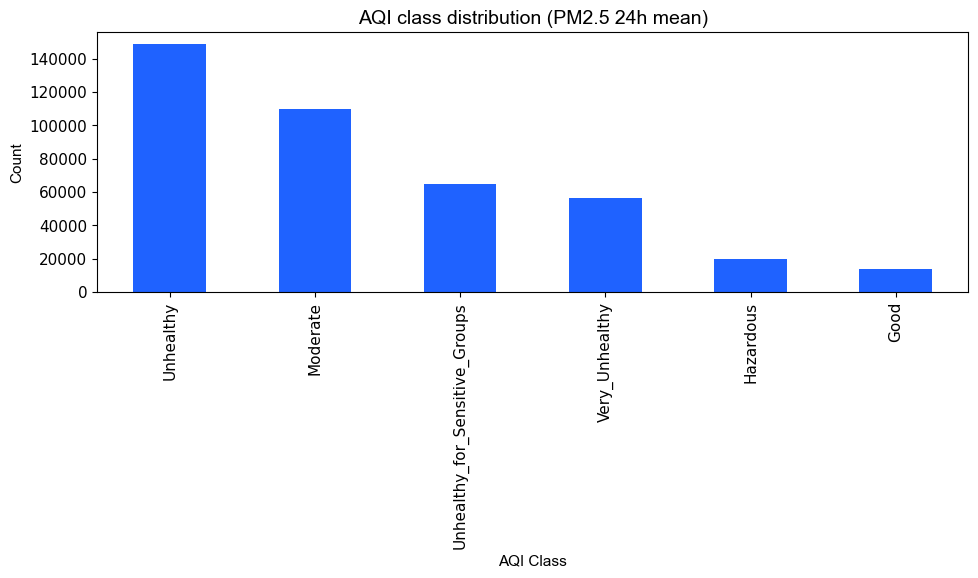

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
class_dist.drop(index=[x for x in class_dist.index if pd.isna(x)], errors='ignore').plot(kind='bar', ax=ax, color='#1F62FF')
ax.set_title('AQI class distribution (PM2.5 24h mean)', fontsize=14, fontfamily='Arial')
ax.set_ylabel('Count', fontsize=11, fontfamily='Arial')
ax.set_xlabel('AQI Class', fontsize=11, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '01_class_distribution.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '01_class_distribution.png')
plt.show()

In [8]:
df.to_parquet(OUT_PATH, index=False)
print('Saved:', OUT_PATH)

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\01_cleaned.parquet


C:\Users\ThanhTung\AppData\Local\Temp\ipykernel_2848\1341727428.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_monthly = pm25_pivot.isna().resample('M').mean()


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\01_missing_data_heatmap.png


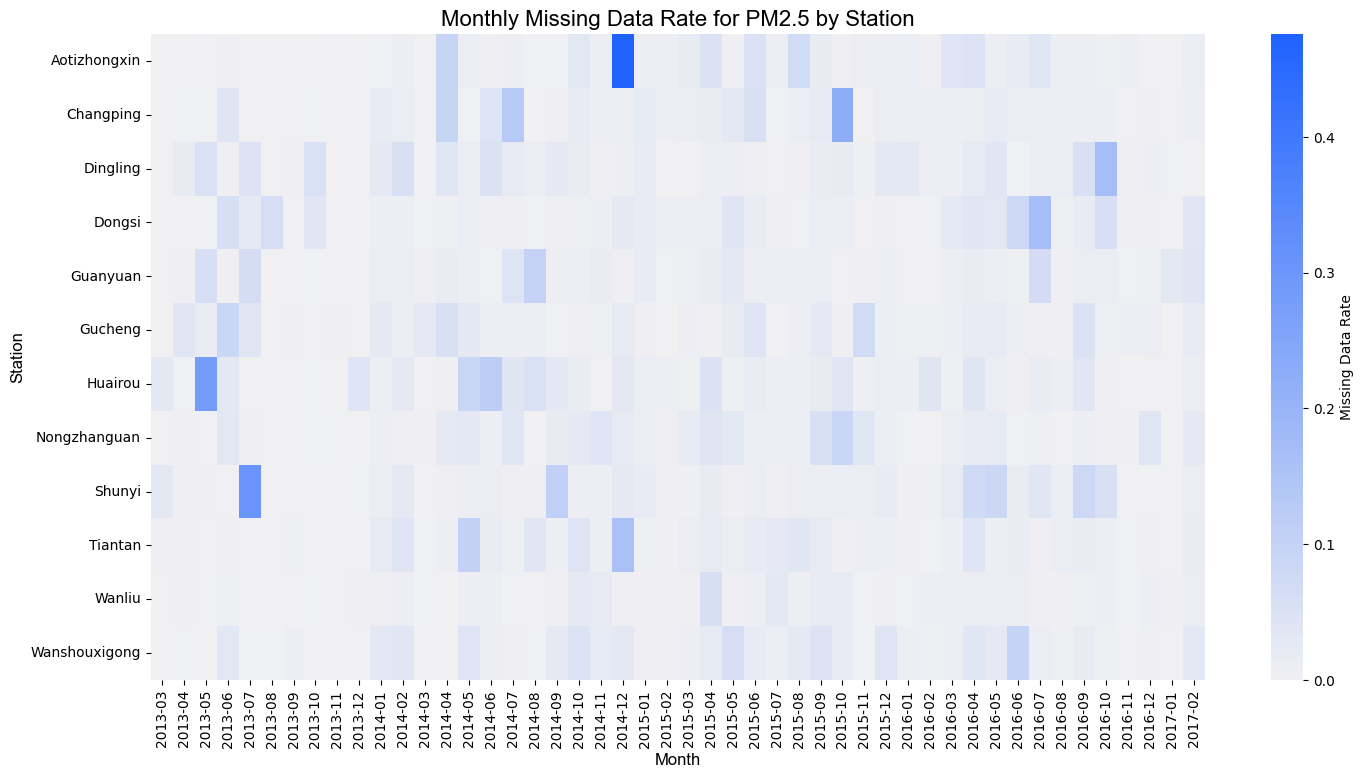

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo một bảng pivot để xem xét mô hình dữ liệu bị thiếu theo thời gian cho mỗi trạm
# Chúng ta sẽ tập trung vào PM2.5 là biến chính
pm25_pivot = df.pivot_table(index='datetime', columns='station', values='PM2.5')

# Lấy mẫu lại theo tháng và tính toán tỷ lệ dữ liệu bị thiếu cho mỗi tháng
# .isna() tạo ra một ma trận boolean, .resample('M').mean() tính toán giá trị trung bình hàng tháng của các giá trị True (dữ liệu bị thiếu)
missing_monthly = pm25_pivot.isna().resample('M').mean()

# Chuyển vị để có hình ảnh trực quan tốt hơn (các trạm trên trục y)
missing_monthly = missing_monthly.transpose()

# Tạo heatmap
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    missing_monthly, 
    cmap=sns.color_palette("light:#1F62FF", as_cmap=True), # Gradient màu xanh dương
    ax=ax,
    cbar_kws={'label': 'Missing Data Rate'}
)

# Định dạng
ax.set_title('Monthly Missing Data Rate for PM2.5 by Station', fontsize=16, fontfamily='Arial')
ax.set_xlabel('Month', fontsize=12, fontfamily='Arial')
ax.set_ylabel('Station', fontsize=12, fontfamily='Arial')

# Định dạng nhãn trục x để hiển thị Năm-Tháng
xticklabels = [item.strftime('%Y-%m') for item in missing_monthly.columns]
ax.set_xticklabels(xticklabels, rotation=90, ha='center')

plt.tight_layout(pad=1.5)

# Lưu biểu đồ
save_path = IMAGES_PATH / '01_missing_data_heatmap.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f'Saved: {save_path}')

plt.show()